# Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import json
import torch
import torch.nn as nn
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from pypfopt import HRPOpt
import matplotlib.pyplot as plt
from skorch import NeuralNetClassifier
from scipy.stats import ttest_rel
import matplotlib.dates as mdates
from sklearn.metrics import f1_score

# Loading Data and Seperating Feature/Target 

In [2]:

# Load the data
file_name = "top_100_sp500_stock_data.csv"
#file_name = "top_7_sp500_stock_data.csv" # Used for testing models first
all_stocks_data = pd.read_csv(file_name)

# Create the target variable
all_stocks_data['Return_90d'] = (
    all_stocks_data.groupby('Ticker')['Close'].shift(-90) / all_stocks_data['Close'] - 1
)

# Modify the target variable to have labels 0 and 1
all_stocks_data['Target'] = (all_stocks_data['Return_90d'] > 0).astype(int)

# Drop rows with NaN values
all_stocks_data.dropna(inplace=True)

# Select features
feature_columns = [
    col for col in all_stocks_data.columns if col not in ['Ticker', 'Return_90d', 'Target', 'Date']
]
X = all_stocks_data[feature_columns]
y = all_stocks_data['Target']

# Handle infinity values
X = X.replace([np.inf, -np.inf], np.nan)

# Remove rows with NaN values
X = X.dropna()
y = y.loc[X.index]  

# Set up Random Search Parameters

In [3]:
# Define the parameter grid
param_dist = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

# Initialize Start and End Year.
start_year = 2014
end_year = 2023
yearly_results = []
trained_models = []

# Define feature columns
feature_columns = [
    col for col in all_stocks_data.columns if col not in ['Ticker', 'Return_90d', 'Target', 'Date']
]

# Initialize MinMaxScaler
scaler = MinMaxScaler()


## Check and Load Hyperparameters from JSON File


## Loop Through Years and Process Data for Each Year

In [4]:
# We will read from th JSON file so we don't have to rerun the model everytime.
try:
    xgb_best_models = json.load(open("xgb_hyper_params.json"))
except FileNotFoundError:
    open("xgb_hyper_params.json", "x").write("{}")
    xgb_best_models = {}

# Adjust yearly data processing to include the first 30 and last 90 days
for year in range(start_year, end_year + 1):
    with open("xgb_hyper_params.json", "w") as f:
        f.write(json.dumps(xgb_best_models))
    
    print(f"\nProcessing year {year}...")

    # Filter data for the current year
    current_year_data = all_stocks_data[
        (all_stocks_data['Date'] >= f"{year}-01-01") & 
        (all_stocks_data['Date'] <= f"{year}-12-31")
    ]

    # Get data for the previous year to handle the first 30 days
    previous_year_data = all_stocks_data[
        (all_stocks_data['Date'] >= f"{year - 1}-12-01") & 
        (all_stocks_data['Date'] <= f"{year - 1}-12-31")
    ]

    # Get data for the next year to handle the last 90 days
    next_year_data = all_stocks_data[
        (all_stocks_data['Date'] >= f"{year + 1}-01-01") & 
        (all_stocks_data['Date'] <= f"{year + 1}-03-31")
    ]

    # Concatenate previous, current, and next year's data where applicable
    yearly_data = pd.concat([previous_year_data, current_year_data, next_year_data])

    # Skip the year if no data is available
    if yearly_data.empty:
        continue

    # Select features and target for the year
    X_year = yearly_data[feature_columns]
    y_year = yearly_data['Target']

    # Handle missing or infinity values
    X_year = X_year.replace([np.inf, -np.inf], np.nan).dropna()
    y_year = y_year.loc[X_year.index]

    # Skip if the filtered X_year is empty
    if X_year.empty:
        continue

    # Reset indices of both X_year and y_year for alignment
    X_year = X_year.reset_index(drop=True)
    y_year = y_year.reset_index(drop=True)

    # Normalize the features using the scaler
    X_year_scaled = scaler.fit_transform(X_year)

    # Split the data into Training (60%) and Temp (40%) sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_year_scaled, y_year, test_size=0.4, random_state=42, stratify=y_year
    )

    # Split Temp set into Validation (20%) and Test (20%) sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Debugging: Check data splits
    #print(f"Training Set Size: {X_train.shape[0]} samples")
    #print(f"Validation Set Size: {X_val.shape[0]} samples")
    #print(f"Testing Set Size: {X_test.shape[0]} samples")
    if str(year) not in xgb_best_models:
        # Instantiate the XGBClassifier with GPU support
        xgb_model = XGBClassifier(
            random_state=42, 
            eval_metric='logloss', 
            tree_method='gpu_hist',  # Use GPU for histogram building
            predictor='gpu_predictor'  # Use GPU for prediction
        )

        # Set up Stratified K-Fold Cross-Validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # RandomizedSearchCV with `cv=skf`
        random_search = RandomizedSearchCV(
            estimator=xgb_model,
            param_distributions=param_dist,
            n_iter=50,
            scoring='accuracy',
            cv=skf,
            verbose=2,
            random_state=42,
            n_jobs=6
        )

        # Perform the random search (This is done on training data)
        random_search.fit(X_train, y_train)
        
        best_xgb_model = random_search.best_estimator_    
        print(f"Best Hyperparameters for {year}:", random_search.best_params_)
        xgb_best_models[str(year)] = random_search.best_params_
        # Store the trained model and yearly data for evaluation
        trained_models.append((best_xgb_model, random_search.best_params_))
        yearly_results.append((X_year_scaled, y_year, yearly_data.reset_index(drop=True)))
        with open("xgb_hyper_params.json", "w") as f:
            f.write(json.dumps(xgb_best_models))
    else:
        best_xgb_model = XGBClassifier(
            random_state=42, 
            eval_metric='logloss', 
            tree_method='gpu_hist',  # Use GPU for histogram building
            predictor='gpu_predictor',  # Use GPU for prediction
            **xgb_best_models[str(year)]
        )
        trained_models.append((best_xgb_model, xgb_best_models[str(year)]))
        yearly_results.append((X_year_scaled, y_year, yearly_data.reset_index(drop=True)))
        

    # Print the best hyperparameters
    

    print(f"Year {year} processing completed.")


Processing year 2014...
Year 2014 processing completed.

Processing year 2015...
Year 2015 processing completed.

Processing year 2016...
Year 2016 processing completed.

Processing year 2017...
Year 2017 processing completed.

Processing year 2018...
Year 2018 processing completed.

Processing year 2019...
Year 2019 processing completed.

Processing year 2020...
Year 2020 processing completed.

Processing year 2021...
Year 2021 processing completed.

Processing year 2022...
Year 2022 processing completed.

Processing year 2023...
Year 2023 processing completed.


In [5]:
with open("xgb_hyper_params.json", "w") as f:
    f.write(json.dumps(xgb_best_models))

# Make an XGBoost Classifier with the best parameters

In [6]:
# Initialize a dictionary to store models and F1-scores for each year
yearly_models = {}
f1_scores_per_year = {}  

# Function to evaluate and print metrics while saving F1-scores
def evaluate_model(model, X, y, dataset_name, year):
    # Debugging: Check if f1_score is callable
    print(f"Type of f1_score before calling: {type(f1_score)}")  # Debugging line

    # Ensure that no shadowing occurs for f1_score
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1_result = f1_score(y, y_pred, average='weighted')  # Explicitly call f1_score from sklearn
    print(f"\n{dataset_name} Accuracy: {accuracy:.2f}")
    print(f"{dataset_name} F1-Score: {f1_result:.4f}")
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y, y_pred))
    print(f"{dataset_name} Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

    # Save F1-scores for the test set only
    if "Test Set" in dataset_name:
        f1_scores_per_year[year] = f1_result  # Save the result in the dictionary

# Loop through each year and train/evaluate the model
for year, (X_year_scaled, y_year, yearly_data) in zip(range(start_year, end_year + 1), yearly_results):
    print(f"\nTraining and evaluating XGBoost model for year {year}...")

    # Retrieve best hyperparameters for the year
    best_params = trained_models[year - start_year][1]

    # Create a new XGBoost classifier with the best parameters
    xgb_model = XGBClassifier(
        **best_params,
        random_state=42,
        eval_metric='logloss',
        tree_method='gpu_hist',  # Ensure GPU usage
        predictor='gpu_predictor'
    )

    # Split the yearly data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_year_scaled, y_year, test_size=0.4, random_state=42, stratify=y_year
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Train the XGBoost classifier
    xgb_model.fit(X_train, y_train)

    # Evaluate the model on training, validation, and test sets
    evaluate_model(xgb_model, X_train, y_train, f"Year {year} - Training Set", year)
    evaluate_model(xgb_model, X_val, y_val, f"Year {year} - Validation Set", year)
    evaluate_model(xgb_model, X_test, y_test, f"Year {year} - Test Set", year)

    # Store the trained model for the year
    yearly_models[year] = xgb_model

# Print the saved F1-scores
print("\nF1-Scores for XGBoost across all years (Test Set):")
for year, f1_score_value in f1_scores_per_year.items():
    print(f"Year {year}: F1-Score = {f1_score_value:.4f}")

print("\nAll yearly models have been trained, evaluated, and F1-scores saved.")


Training and evaluating XGBoost model for year 2014...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2014 - Training Set Accuracy: 1.00
Year 2014 - Training Set F1-Score: 1.0000
Year 2014 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4945
           1       1.00      1.00      1.00     10709

    accuracy                           1.00     15654
   macro avg       1.00      1.00      1.00     15654
weighted avg       1.00      1.00      1.00     15654

Year 2014 - Training Set Confusion Matrix:
[[ 4945     0]
 [    0 10709]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for b


Year 2014 - Validation Set Accuracy: 0.90
Year 2014 - Validation Set F1-Score: 0.8987
Year 2014 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1649
           1       0.90      0.96      0.93      3569

    accuracy                           0.90      5218
   macro avg       0.90      0.86      0.88      5218
weighted avg       0.90      0.90      0.90      5218

Year 2014 - Validation Set Confusion Matrix:
[[1264  385]
 [ 131 3438]]
Type of f1_score before calling: <class 'function'>

Year 2014 - Test Set Accuracy: 0.89
Year 2014 - Test Set F1-Score: 0.8898
Year 2014 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.81      1648
           1       0.89      0.96      0.92      3570

    accuracy                           0.89      5218
   macro avg       0.89      0.85      0.87      5218
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2015 - Training Set Accuracy: 1.00
Year 2015 - Training Set F1-Score: 1.0000
Year 2015 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8189
           1       1.00      1.00      1.00     11314

    accuracy                           1.00     19503
   macro avg       1.00      1.00      1.00     19503
weighted avg       1.00      1.00      1.00     19503

Year 2015 - Training Set Confusion Matrix:
[[ 8189     0]
 [    0 11314]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2015 - Validation Set Accuracy: 0.87
Year 2015 - Validation Set F1-Score: 0.8681
Year 2015 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      2730
           1       0.86      0.93      0.89      3771

    accuracy                           0.87      6501
   macro avg       0.87      0.86      0.86      6501
weighted avg       0.87      0.87      0.87      6501

Year 2015 - Validation Set Confusion Matrix:
[[2137  593]
 [ 255 3516]]
Type of f1_score before calling: <class 'function'>

Year 2015 - Test Set Accuracy: 0.88
Year 2015 - Test Set F1-Score: 0.8741
Year 2015 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      2730
           1       0.86      0.94      0.90      3771

    accuracy                           0.88      6501
   macro avg       0.88      0.86      0.87      6501
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2016 - Training Set Accuracy: 1.00
Year 2016 - Training Set F1-Score: 1.0000
Year 2016 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4750
           1       1.00      1.00      1.00     14889

    accuracy                           1.00     19639
   macro avg       1.00      1.00      1.00     19639
weighted avg       1.00      1.00      1.00     19639

Year 2016 - Training Set Confusion Matrix:
[[ 4750     0]
 [    0 14889]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2016 - Validation Set Accuracy: 0.90
Year 2016 - Validation Set F1-Score: 0.8995
Year 2016 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.67      0.77      1583
           1       0.90      0.98      0.94      4963

    accuracy                           0.90      6546
   macro avg       0.91      0.82      0.86      6546
weighted avg       0.91      0.90      0.90      6546

Year 2016 - Validation Set Confusion Matrix:
[[1059  524]
 [  98 4865]]
Type of f1_score before calling: <class 'function'>

Year 2016 - Test Set Accuracy: 0.90
Year 2016 - Test Set F1-Score: 0.8966
Year 2016 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1584
           1       0.90      0.98      0.94      4963

    accuracy                           0.90      6547
   macro avg       0.91      0.82      0.85      6547
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2017 - Training Set Accuracy: 1.00
Year 2017 - Training Set F1-Score: 1.0000
Year 2017 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5342
           1       1.00      1.00      1.00     14238

    accuracy                           1.00     19580
   macro avg       1.00      1.00      1.00     19580
weighted avg       1.00      1.00      1.00     19580

Year 2017 - Training Set Confusion Matrix:
[[ 5342     0]
 [    0 14238]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2017 - Validation Set Accuracy: 0.92
Year 2017 - Validation Set F1-Score: 0.9194
Year 2017 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1781
           1       0.93      0.97      0.95      4746

    accuracy                           0.92      6527
   macro avg       0.91      0.88      0.90      6527
weighted avg       0.92      0.92      0.92      6527

Year 2017 - Validation Set Confusion Matrix:
[[1429  352]
 [ 165 4581]]
Type of f1_score before calling: <class 'function'>

Year 2017 - Test Set Accuracy: 0.92
Year 2017 - Test Set F1-Score: 0.9161
Year 2017 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1781
           1       0.92      0.97      0.94      4746

    accuracy                           0.92      6527
   macro avg       0.91      0.88      0.89      6527
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2018 - Training Set Accuracy: 1.00
Year 2018 - Training Set F1-Score: 1.0000
Year 2018 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7509
           1       1.00      1.00      1.00     11953

    accuracy                           1.00     19462
   macro avg       1.00      1.00      1.00     19462
weighted avg       1.00      1.00      1.00     19462

Year 2018 - Training Set Confusion Matrix:
[[ 7509     0]
 [    0 11953]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2018 - Validation Set Accuracy: 0.90
Year 2018 - Validation Set F1-Score: 0.8968
Year 2018 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      2503
           1       0.89      0.95      0.92      3985

    accuracy                           0.90      6488
   macro avg       0.90      0.88      0.89      6488
weighted avg       0.90      0.90      0.90      6488

Year 2018 - Validation Set Confusion Matrix:
[[2032  471]
 [ 190 3795]]
Type of f1_score before calling: <class 'function'>

Year 2018 - Test Set Accuracy: 0.89
Year 2018 - Test Set F1-Score: 0.8852
Year 2018 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      2503
           1       0.88      0.95      0.91      3985

    accuracy                           0.89      6488
   macro avg       0.89      0.87      0.88      6488
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2019 - Training Set Accuracy: 1.00
Year 2019 - Training Set F1-Score: 1.0000
Year 2019 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7145
           1       1.00      1.00      1.00     12345

    accuracy                           1.00     19490
   macro avg       1.00      1.00      1.00     19490
weighted avg       1.00      1.00      1.00     19490

Year 2019 - Training Set Confusion Matrix:
[[ 7145     0]
 [    0 12345]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2019 - Validation Set Accuracy: 0.91
Year 2019 - Validation Set F1-Score: 0.9045
Year 2019 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      2382
           1       0.90      0.96      0.93      4115

    accuracy                           0.91      6497
   macro avg       0.91      0.89      0.90      6497
weighted avg       0.91      0.91      0.90      6497

Year 2019 - Validation Set Confusion Matrix:
[[1928  454]
 [ 157 3958]]
Type of f1_score before calling: <class 'function'>

Year 2019 - Test Set Accuracy: 0.90
Year 2019 - Test Set F1-Score: 0.8965
Year 2019 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      2382
           1       0.89      0.96      0.92      4115

    accuracy                           0.90      6497
   macro avg       0.90      0.88      0.89      6497
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2020 - Training Set Accuracy: 1.00
Year 2020 - Training Set F1-Score: 1.0000
Year 2020 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5415
           1       1.00      1.00      1.00     14333

    accuracy                           1.00     19748
   macro avg       1.00      1.00      1.00     19748
weighted avg       1.00      1.00      1.00     19748

Year 2020 - Training Set Confusion Matrix:
[[ 5415     0]
 [    0 14333]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2020 - Validation Set Accuracy: 0.91
Year 2020 - Validation Set F1-Score: 0.9007
Year 2020 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      1805
           1       0.90      0.98      0.94      4778

    accuracy                           0.91      6583
   macro avg       0.92      0.84      0.87      6583
weighted avg       0.91      0.91      0.90      6583

Year 2020 - Validation Set Confusion Matrix:
[[1268  537]
 [  86 4692]]
Type of f1_score before calling: <class 'function'>

Year 2020 - Test Set Accuracy: 0.90
Year 2020 - Test Set F1-Score: 0.8946
Year 2020 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1805
           1       0.90      0.97      0.93      4778

    accuracy                           0.90      6583
   macro avg       0.90      0.84      0.86      6583
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2021 - Training Set Accuracy: 1.00
Year 2021 - Training Set F1-Score: 1.0000
Year 2021 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8542
           1       1.00      1.00      1.00     11417

    accuracy                           1.00     19959
   macro avg       1.00      1.00      1.00     19959
weighted avg       1.00      1.00      1.00     19959

Year 2021 - Training Set Confusion Matrix:
[[ 8542     0]
 [    0 11417]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2021 - Validation Set Accuracy: 0.90
Year 2021 - Validation Set F1-Score: 0.9038
Year 2021 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      2847
           1       0.90      0.93      0.92      3806

    accuracy                           0.90      6653
   macro avg       0.90      0.90      0.90      6653
weighted avg       0.90      0.90      0.90      6653

Year 2021 - Validation Set Confusion Matrix:
[[2461  386]
 [ 252 3554]]
Type of f1_score before calling: <class 'function'>

Year 2021 - Test Set Accuracy: 0.91
Year 2021 - Test Set F1-Score: 0.9115
Year 2021 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2847
           1       0.91      0.94      0.92      3806

    accuracy                           0.91      6653
   macro avg       0.91      0.91      0.91      6653
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2022 - Training Set Accuracy: 1.00
Year 2022 - Training Set F1-Score: 1.0000
Year 2022 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10124
           1       1.00      1.00      1.00      9856

    accuracy                           1.00     19980
   macro avg       1.00      1.00      1.00     19980
weighted avg       1.00      1.00      1.00     19980

Year 2022 - Training Set Confusion Matrix:
[[10124     0]
 [    0  9856]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2022 - Validation Set Accuracy: 0.89
Year 2022 - Validation Set F1-Score: 0.8919
Year 2022 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3375
           1       0.89      0.89      0.89      3285

    accuracy                           0.89      6660
   macro avg       0.89      0.89      0.89      6660
weighted avg       0.89      0.89      0.89      6660

Year 2022 - Validation Set Confusion Matrix:
[[3020  355]
 [ 365 2920]]
Type of f1_score before calling: <class 'function'>

Year 2022 - Test Set Accuracy: 0.90
Year 2022 - Test Set F1-Score: 0.9009
Year 2022 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3375
           1       0.90      0.90      0.90      3285

    accuracy                           0.90      6660
   macro avg       0.90      0.90      0.90      6660
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2023 - Training Set Accuracy: 1.00
Year 2023 - Training Set F1-Score: 1.0000
Year 2023 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6355
           1       1.00      1.00      1.00     13565

    accuracy                           1.00     19920
   macro avg       1.00      1.00      1.00     19920
weighted avg       1.00      1.00      1.00     19920

Year 2023 - Training Set Confusion Matrix:
[[ 6355     0]
 [    0 13565]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2023 - Validation Set Accuracy: 0.91
Year 2023 - Validation Set F1-Score: 0.9084
Year 2023 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2118
           1       0.91      0.97      0.94      4522

    accuracy                           0.91      6640
   macro avg       0.91      0.88      0.89      6640
weighted avg       0.91      0.91      0.91      6640

Year 2023 - Validation Set Confusion Matrix:
[[1677  441]
 [ 155 4367]]
Type of f1_score before calling: <class 'function'>

Year 2023 - Test Set Accuracy: 0.90
Year 2023 - Test Set F1-Score: 0.9015
Year 2023 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      2119
           1       0.90      0.96      0.93      4521

    accuracy                           0.90      6640
   macro avg       0.91      0.87      0.88      6640
weighted avg       0.

# Stock Ranking Using The Model

In [7]:
# Initialize a dictionary to store ranked stocks for each year
yearly_ranked_stocks = {}

for year, (X_year_scaled, y_year, yearly_data) in zip(range(start_year, end_year + 1), yearly_results):
    print(f"\nRanking stocks for year {year}...")

    # Get the trained model for the year
    xgb_model = yearly_models[year]

    # Extract tickers and scaled features for the current year
    tickers = yearly_data['Ticker']

    # Ensure tickers align with the scaled features
    tickers = tickers.iloc[:X_year_scaled.shape[0]]

    # Debugging: Check the lengths again
    print(f"Number of tickers (aligned): {len(tickers)}")
    print(f"Number of features (scaled): {X_year_scaled.shape[0]}")

    # Make predictions using the XGBoost model
    probabilities = xgb_model.predict_proba(X_year_scaled)[:, 1]

    # Debugging: Check the length of probabilities
    print(f"Number of probabilities: {len(probabilities)}")

    # Create a DataFrame with tickers and their corresponding probabilities
    ranked_stocks = pd.DataFrame({
        'Ticker': tickers.values,  # Use .values to align with probabilities
        'Probability_of_Positive_Return': probabilities
    })

    # Aggregate the probabilities by ticker using the mean
    ranked_stocks = ranked_stocks.groupby('Ticker', as_index=False)['Probability_of_Positive_Return'].mean()

    # Sort the stocks by mean probability in descending order
    ranked_stocks = ranked_stocks.sort_values(by='Probability_of_Positive_Return', ascending=False).reset_index(drop=True)

    # Store the ranked stocks for the year
    yearly_ranked_stocks[year] = ranked_stocks

    # Display the top-ranked stocks for the year
    print(f"Top 5 ranked stocks for {year}:")
    print(ranked_stocks.head())

print("\nAll yearly rankings have been generated.")



Ranking stocks for year 2014...
Number of tickers (aligned): 26090
Number of features (scaled): 26090
Number of probabilities: 26090
Top 5 ranked stocks for 2014:
  Ticker  Probability_of_Positive_Return
0    LLY                        0.983776
1    DIS                        0.981637
2   PANW                        0.977498
3   AVGO                        0.976305
4   VRTX                        0.966828

Ranking stocks for year 2015...
Number of tickers (aligned): 32505
Number of features (scaled): 32505
Number of probabilities: 32505
Top 5 ranked stocks for 2015:
  Ticker  Probability_of_Positive_Return
0   META                        0.959890
1     MO                        0.932688
2     FI                        0.920114
3     HD                        0.905535
4   ADBE                        0.901757

Ranking stocks for year 2016...
Number of tickers (aligned): 32732
Number of features (scaled): 32732
Number of probabilities: 32732
Top 5 ranked stocks for 2016:
  Ticker  Probab

# Apply HRP to Top n Stocks and Build Portfolio

In [8]:
# Initialize variables
initial_investment = 100
portfolio_value = initial_investment
cumulative_portfolio_returns = []
yearly_adjusted_weights = {}

# Iterate through yearly ranked stocks and calculate adjusted HRP weights
for year, ranked_stocks in yearly_ranked_stocks.items():
    print(f"\nApplying HRP for year {year}...")

    # Select the top 40 ranked stocks
    top_ranked_stocks = ranked_stocks.head(40)
    tickers = top_ranked_stocks['Ticker']
    filtered_data = all_stocks_data[all_stocks_data['Ticker'].isin(tickers)]

    # Pivot to get price data
    price_data = filtered_data.pivot(index='Date', columns='Ticker', values='Close')

    # Handle missing data
    if price_data.isnull().any().any():
        print(f"Missing values found in price data for {year}. Handling them...")
        price_data = price_data.ffill().bfill()

    # Calculate daily returns
    returns = price_data.pct_change().dropna()

    # Apply HRP algorithm
    hrp = HRPOpt(returns)
    hrp_weights = hrp.optimize()

    # Convert HRP weights to DataFrame
    hrp_weights_df = pd.DataFrame.from_dict(hrp_weights, orient='index', columns=['Weight'])
    hrp_weights_df.index.name = 'Ticker'
    hrp_weights_df.sort_values(by='Weight', ascending=False, inplace=True)

    # Adjust weights using probabilities
    probabilities = top_ranked_stocks.set_index('Ticker')['Probability_of_Positive_Return']
    aligned_probabilities = probabilities.reindex(hrp_weights_df.index).dropna()
    hrp_weights_df = hrp_weights_df.loc[aligned_probabilities.index]

    # Calculate adjusted weights
    adjusted_weights = hrp_weights_df['Weight'] * aligned_probabilities
    adjusted_weights /= adjusted_weights.sum()

    # Create adjusted weights DataFrame
    adjusted_weights_df = adjusted_weights.to_frame('Adjusted Weight')
    adjusted_weights_df.index.name = 'Ticker'
    adjusted_weights_df.sort_values(by='Adjusted Weight', ascending=False, inplace=True)

    # Store the adjusted weights
    yearly_adjusted_weights[year] = adjusted_weights_df

    print(f"\nAdjusted HRP Weights for Top 40 Ranked Stocks for {year}:")
    print(adjusted_weights_df.head())



Applying HRP for year 2014...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.62463333 0.62463333 0.62463333 0.62463333 0.62463333 0.62463333
 0.62463333 0.62463333 0.62463333 0.62463333 0.62463333 0.62463333
 0.62463333 0.62463333 0.62463333 0.62463333 0.62463333 0.62463333
 0.62463333 0.62463333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2014:
        Adjusted Weight
Ticker                 
PEP            0.055672
MO             0.053128
LMT            0.049486
MMC            0.045660
COST           0.040751

Applying HRP for year 2015...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.65442768 0.65442768 0.65442768 0.65442768 0.65442768 0.65442768
 0.65442768 0.65442768 0.65442768 0.65442768 0.65442768 0.65442768
 0.65442768 0.65442768 0.65442768 0.65442768 0.65442768 0.65442768
 0.65442768 0.65442768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2015:
        Adjusted Weight
Ticker                 
MCD            0.055233
KO             0.053349
PEP            0.053262
LMT            0.052386
PGR            0.049014

Applying HRP for year 2016...
Missing values found in price data for 2016. Handling them...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.53331504 0.53331504 0.53331504 0.53331504 0.53331504 0.53331504
 0.53331504 0.53331504 0.53331504 0.53331504 0.53331504 0.53331504
 0.53331504 0.53331504 0.53331504 0.53331504 0.53331504 0.53331504
 0.53331504 0.53331504]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2016:
        Adjusted Weight
Ticker                 
LMT            0.071813
MMC            0.051092
CMCSA          0.049275
TMUS           0.046763
RTX            0.040944

Applying HRP for year 2017...
Missing values found in price data for 2017. Handling them...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.60208803 0.60208803 0.60208803 0.60208803 0.60208803 0.60208803
 0.60208803 0.60208803 0.60208803 0.60208803 0.60208803 0.60208803
 0.60208803 0.60208803 0.60208803 0.60208803 0.60208803 0.60208803
 0.60208803 0.60208803]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2017:
        Adjusted Weight
Ticker                 
PGR            0.063020
NEE            0.053060
UNP            0.042075
ABT            0.041411
LIN            0.040482

Applying HRP for year 2018...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.63380427 0.63380427 0.63380427 0.63380427 0.63380427 0.63380427
 0.63380427 0.63380427 0.63380427 0.63380427 0.63380427 0.63380427
 0.63380427 0.63380427 0.63380427 0.63380427 0.63380427 0.63380427
 0.63380427 0.63380427]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2018:
        Adjusted Weight
Ticker                 
VZ             0.055081
MRK            0.049884
COST           0.048715
KO             0.044439
PEP            0.042685

Applying HRP for year 2019...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.62981365 0.62981365 0.62981365 0.62981365 0.62981365 0.62981365
 0.62981365 0.62981365 0.62981365 0.62981365 0.62981365 0.62981365
 0.62981365 0.62981365 0.62981365 0.62981365 0.62981365 0.62981365
 0.62981365 0.62981365]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2019:
        Adjusted Weight
Ticker                 
PG             0.069666
COST           0.069221
WMT            0.062614
LMT            0.056793
TMUS           0.040729

Applying HRP for year 2020...
Missing values found in price data for 2020. Handling them...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.60574158 0.60574158 0.60574158 0.60574158 0.60574158 0.60574158
 0.60574158 0.60574158 0.60574158 0.60574158 0.60574158 0.60574158
 0.60574158 0.60574158 0.60574158 0.60574158 0.60574158 0.60574158
 0.60574158 0.60574158]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2020:
        Adjusted Weight
Ticker                 
UNH            0.052144
LLY            0.047969
TMUS           0.046755
CMCSA          0.041761
COST           0.040131

Applying HRP for year 2021...
Missing values found in price data for 2021. Handling them...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5335991 0.5335991 0.5335991 0.5335991 0.5335991 0.5335991 0.5335991
 0.5335991 0.5335991 0.5335991 0.5335991 0.5335991 0.5335991 0.5335991
 0.5335991 0.5335991 0.5335991 0.5335991 0.5335991 0.5335991]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2021:
        Adjusted Weight
Ticker                 
JNJ            0.050902
PG             0.047111
MMC            0.046781
MRK            0.046008
COST           0.043719

Applying HRP for year 2022...
Missing values found in price data for 2022. Handling them...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.62865256 0.62865256 0.62865256 0.62865256 0.62865256 0.62865256
 0.62865256 0.62865256 0.62865256 0.62865256 0.62865256 0.62865256
 0.62865256 0.62865256 0.62865256 0.62865256 0.62865256 0.62865256
 0.62865256 0.62865256]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2022:
        Adjusted Weight
Ticker                 
MRK            0.070965
PEP            0.063131
WMT            0.051820
PGR            0.051197
KO             0.048867

Applying HRP for year 2023...
Missing values found in price data for 2023. Handling them...

Adjusted HRP Weights for Top 40 Ranked Stocks for 2023:
        Adjusted Weight
Ticker                 
PG             0.082819
COST           0.068309
WMT            0.060805
LLY            0.059453
LIN            0.042624


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.60999151 0.60999151 0.60999151 0.60999151 0.60999151 0.60999151
 0.60999151 0.60999151 0.60999151 0.60999151 0.60999151 0.60999151
 0.60999151 0.60999151 0.60999151 0.60999151 0.60999151 0.60999151
 0.60999151 0.60999151]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


# Backtest Our Portfolio


Simulating portfolio for year 2014...

Simulating portfolio for year 2015...

Simulating portfolio for year 2016...

Simulating portfolio for year 2017...

Simulating portfolio for year 2018...

Simulating portfolio for year 2019...

Simulating portfolio for year 2020...

Simulating portfolio for year 2021...

Simulating portfolio for year 2022...

Simulating portfolio for year 2023...


[*********************100%***********************]  1 of 1 completed


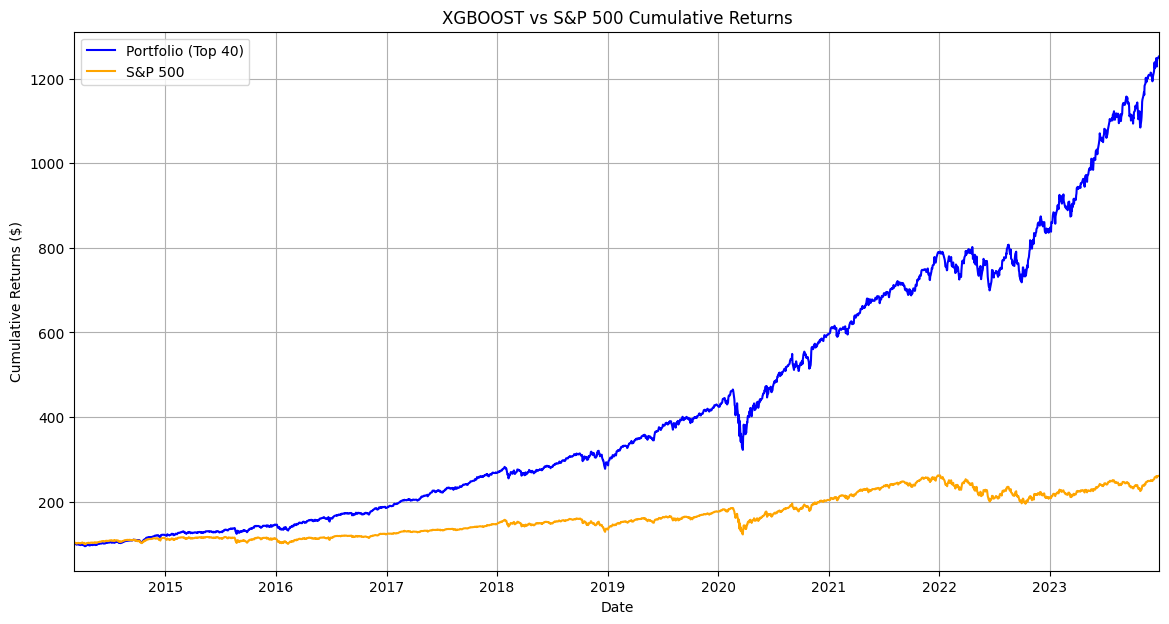

In [9]:

# Simulate portfolio performance year by year
for year, adjusted_weights_df in yearly_adjusted_weights.items():
    print(f"\nSimulating portfolio for year {year}...")

    # Filter data for the selected tickers
    tickers = adjusted_weights_df.index
    filtered_data = all_stocks_data[all_stocks_data['Ticker'].isin(tickers)]
    price_data_year = filtered_data.pivot(index='Date', columns='Ticker', values='Close')
    price_data_year = price_data_year.loc[f"{year}-01-01":f"{year}-12-31"]

    # Handle missing data
    price_data_year = price_data_year.ffill().bfill()

    # Calculate daily returns
    returns_year = price_data_year.pct_change().dropna()

    # Calculate weighted portfolio returns
    portfolio_returns = returns_year[adjusted_weights_df.index]
    weighted_returns = portfolio_returns.mul(adjusted_weights_df['Adjusted Weight'], axis=1)
    portfolio_daily_returns = weighted_returns.sum(axis=1)

    # Calculate cumulative returns
    yearly_cumulative_returns = (1 + portfolio_daily_returns).cumprod()
    yearly_cumulative_returns *= portfolio_value

    # Update portfolio value and store yearly returns
    portfolio_value = yearly_cumulative_returns.iloc[-1]
    cumulative_portfolio_returns.append(yearly_cumulative_returns)

# Combine yearly cumulative returns into a single series
final_cumulative_returns = pd.concat(cumulative_portfolio_returns).sort_index()

# --------------------------------------------
# Step 6: Benchmark and Visualization
# --------------------------------------------
# Download historical price data for S&P 500
sp500_data = yf.download('^GSPC', start=f"{start_year}-01-01", end=f"{end_year}-12-31")['Adj Close']
sp500_returns = sp500_data.pct_change().dropna()
sp500_cumulative_returns = (1 + sp500_returns).cumprod() * initial_investment

# Align indices
sp500_cumulative_returns.index = pd.to_datetime(sp500_cumulative_returns.index)
final_cumulative_returns.index = pd.to_datetime(final_cumulative_returns.index)

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(final_cumulative_returns, label='Portfolio (Top 40)', color='blue')
plt.plot(sp500_cumulative_returns.loc[final_cumulative_returns.index], label='S&P 500', color='orange')
plt.title('XGBOOST vs S&P 500 Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns ($)')
plt.legend()
plt.grid(True)

# Set x-axis to yearly intervals
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(final_cumulative_returns.index.min(), final_cumulative_returns.index.max())

plt.show()

# Comparing Results

In [10]:
# Function to compute performance metrics
def calculate_performance_metrics(returns_series, risk_free_rate=0.0):
    # Check if the series is empty
    if returns_series.empty:
        raise ValueError("The returns series is empty. Check your data and calculations.")

    # Calculate total return
    total_return = returns_series.iloc[-1] / returns_series.iloc[0] - 1

    # Calculate the number of years in the returns series
    num_years = (returns_series.index[-1] - returns_series.index[0]).days / 365.25

    # Calculate annualized return
    annualized_return = (1 + total_return) ** (1 / num_years) - 1

    # Calculate annualized volatility
    annualized_volatility = returns_series.pct_change().std() * np.sqrt(252)

    # Calculate Sharpe ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio
    }

# Calculate metrics for the portfolio
portfolio_metrics = calculate_performance_metrics(final_cumulative_returns)

# Calculate metrics for the S&P 500
sp500_metrics = calculate_performance_metrics(sp500_cumulative_returns)

# Convert S&P 500 metrics into scalar values (remove index metadata)
sp500_metrics_cleaned = {key: float(value) for key, value in sp500_metrics.items()}

# Create a DataFrame with the metrics for comparison
metrics_df = pd.DataFrame(
    [portfolio_metrics, sp500_metrics_cleaned], 
    index=['XGBOOST', 'S&P 500']
)

# Display the metrics
print("\nPortfolio vs. S&P 500 Performance Metrics:")
metrics_df



Portfolio vs. S&P 500 Performance Metrics:


C:\Users\Alec\AppData\Local\Temp\ipykernel_21876\2043128351.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sp500_metrics_cleaned = {key: float(value) for key, value in sp500_metrics.items()}


,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio
XGBOOST,11.505155,0.293617,0.169760,1.729605
S&P 500,1.604515,0.100615,0.177414,0.567120


# LSTM 
### Doesn't use sequencing because each row has 30 lagged days

In [30]:
# Initialize variables
initial_investment = 100
lstm_portfolio_value = initial_investment
lstm_cumulative_portfolio_returns = []
f1_scores_lstm_per_year = {}
try:
    best_lstm_models = json.load(open("ltsm_hyper_params.json"))
except FileNotFoundError:
    open("ltsm_hyper_params.json", "x").write("{}")
    best_lstm_models = {}

# Define feature columns and target
feature_columns = [
    col for col in all_stocks_data.columns if col not in ['Ticker', 'Return_90d', 'Target', 'Date']
]



## Define LSTM Model

In [31]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add time dimension
        lstm_out, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])  # Output from the last hidden layer
        return out


## Hyperparameter Grid for RandomizedSearchCV

In [32]:

param_dist = {
    'module__hidden_size': [50, 100, 150],
    'module__num_layers': [1, 2, 3],
    'lr': [0.001, 0.005, 0.01],
    'iterator_train__batch_size': [16, 32, 64],
    'iterator_valid__batch_size': [16, 32, 64],
    'max_epochs': [25, 50],
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



## Yearly Training and Portfolio Construction

In [26]:
# Function to evaluate and print metrics while saving F1-scores
def evaluate_model(model, X, y, dataset_name, year):
    # Ensure that no shadowing occurs for f1_score
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1_result = f1_score(y, y_pred, average='weighted')  # Explicitly call f1_score from sklearn
    print(f"\n{dataset_name} Accuracy: {accuracy:.2f}")
    print(f"{dataset_name} F1-Score: {f1_result:.4f}")
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y, y_pred))
    print(f"{dataset_name} Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

    # Save F1-scores for the test set only
    if "Test Set" in dataset_name:
        f1_scores_per_year[year] = f1_result  # Save the result in the dictionary

# Loop through each year and train/evaluate the model
for year, (X_year_scaled, y_year, yearly_data) in zip(range(start_year, end_year + 1), yearly_results):
    print(f"\nTraining and evaluating LSTM model for year {year}...")

    # Normalize the features and ensure the correct data type (float32)
    X_year_scaled = X_year_scaled.astype(np.float32)

    # Split the yearly data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_year_scaled, y_year, test_size=0.4, random_state=42, stratify=y_year
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    y_train = y_train.astype(int)

    if str(year) not in best_lstm_models:
        # Wrap LSTM with Skorch for RandomizedSearchCV
        net = NeuralNetClassifier(
            module=LSTMModel,
            module__input_size=X_year_scaled.shape[1],
            module__hidden_size=50,
            module__num_layers=2,
            module__output_size=len(np.unique(y_year)),
            criterion=nn.CrossEntropyLoss,
            optimizer=torch.optim.Adam,
            train_split=None,
            verbose=0,
            device='cuda' if torch.cuda.is_available() else 'cpu',
        )

        # Perform RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=net,
            param_distributions=param_dist,
            n_iter=10,  # Adjust based on computational resources
            scoring='accuracy',
            cv=skf,
            verbose=2,
            random_state=42,
            n_jobs=4
        )

        random_search.fit(X_train.astype(np.float32), y_train)

        # Get the best model and hyperparameters
        best_lstm_model = random_search.best_estimator_
        print(f"\nBest Hyperparameters for {year}: {random_search.best_params_}")
        best_lstm_models[str(year)] = random_search.best_params_
        with open("ltsm_hyper_params.json", "w") as f:
            f.write(json.dumps(best_lstm_models))
    else:
        best_lstm_model = NeuralNetClassifier(
            module=LSTMModel,
            module__input_size=X_year_scaled.shape[1],
            module__output_size=len(np.unique(y_year)),
            criterion=nn.CrossEntropyLoss,
            optimizer=torch.optim.Adam,
            train_split=None,
            verbose=0,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            **best_lstm_models[str(year)]
        )

    # Train the LSTM model
    best_lstm_model.fit(X_train.astype(np.float32), y_train)

    # Evaluate the model on training, validation, and test sets
    evaluate_model(best_lstm_model, X_train.astype(np.float32), y_train, f"Year {year} - Training Set", year)
    evaluate_model(best_lstm_model, X_val.astype(np.float32), y_val, f"Year {year} - Validation Set", year)
    evaluate_model(best_lstm_model, X_test.astype(np.float32), y_test, f"Year {year} - Test Set", year)

    # Store the trained model for the year
    yearly_models[year] = best_lstm_model

    # Save the predicted probabilities for the current year's data
    probabilities_lstm = best_lstm_model.predict_proba(X_year_scaled.astype(np.float32))[:, 1]

    # Ensure tickers align with probabilities
    tickers = yearly_data['Ticker'].iloc[:len(probabilities_lstm)]
    print(f"Tickers length: {len(tickers)}, Probabilities length: {len(probabilities_lstm)}")

    # Create a ranked stocks DataFrame
    ranked_stocks_lstm = pd.DataFrame({
        'Ticker': tickers.values,
        'Probability_of_Positive_Return': probabilities_lstm
    })
    ranked_stocks_lstm = ranked_stocks_lstm.groupby('Ticker', as_index=False)['Probability_of_Positive_Return'].mean()
    ranked_stocks_lstm = ranked_stocks_lstm.sort_values(by='Probability_of_Positive_Return', ascending=False).reset_index(drop=True)

    # Select only the top 40 stocks
    top_40_stocks = ranked_stocks_lstm.head(40)

    # Display the top-ranked stocks for the year
    print(f"Top 5 ranked stocks for {year}:")
    print(top_40_stocks.head())

    # Filter and prepare price data for HRP
    filtered_data_lstm = yearly_data[yearly_data['Ticker'].isin(top_40_stocks['Ticker'])]
    price_data_year_lstm = filtered_data_lstm.pivot(index='Date', columns='Ticker', values='Close').dropna()
    returns_year_lstm = price_data_year_lstm.pct_change().dropna()

    # Apply HRP
    hrp_lstm = HRPOpt(returns_year_lstm)
    hrp_weights_lstm = hrp_lstm.optimize()

    # Adjust HRP weights with probabilities
    hrp_weights_df_lstm = pd.DataFrame.from_dict(hrp_weights_lstm, orient='index', columns=['Weight'])
    hrp_weights_df_lstm.index.name = 'Ticker'
    probabilities_series_lstm = top_40_stocks.set_index('Ticker')['Probability_of_Positive_Return']
    aligned_probabilities_lstm = probabilities_series_lstm.reindex(hrp_weights_df_lstm.index).dropna()
    adjusted_weights_lstm = (hrp_weights_df_lstm['Weight'] * aligned_probabilities_lstm).div(
        (hrp_weights_df_lstm['Weight'] * aligned_probabilities_lstm).sum()
    )
    adjusted_weights_df_lstm = adjusted_weights_lstm.to_frame('Adjusted Weight')

    # Calculate the portfolio's daily returns
    portfolio_returns_lstm = returns_year_lstm[adjusted_weights_df_lstm.index].mul(
        adjusted_weights_df_lstm['Adjusted Weight'], axis=1
    ).sum(axis=1)

    # Calculate cumulative returns for the year
    lstm_yearly_cumulative_returns = (1 + portfolio_returns_lstm).cumprod() * lstm_portfolio_value

    # Update the portfolio value for the end of the year
    lstm_portfolio_value = lstm_yearly_cumulative_returns.iloc[-1]

    # Store cumulative returns for the year
    lstm_cumulative_portfolio_returns.append(lstm_yearly_cumulative_returns)

# Combine yearly returns into a single series
final_lstm_cumulative_returns = pd.concat(lstm_cumulative_portfolio_returns).sort_index()



Training and evaluating LSTM model for year 2014...

Year 2014 - Training Set Accuracy: 0.73
Year 2014 - Training Set F1-Score: 0.6976
Year 2014 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.30      0.41      4945
           1       0.74      0.94      0.83     10709

    accuracy                           0.73     15654
   macro avg       0.71      0.62      0.62     15654
weighted avg       0.72      0.73      0.70     15654

Year 2014 - Training Set Confusion Matrix:
[[ 1466  3479]
 [  672 10037]]

Year 2014 - Validation Set Accuracy: 0.73
Year 2014 - Validation Set F1-Score: 0.6917
Year 2014 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.29      0.40      1649
           1       0.74      0.93      0.82      3569

    accuracy                           0.73      5218
   macro avg       0.70      0.61      0.61      5218
weight

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58422282 0.58422282 0.58422282 0.58422282 0.58422282 0.58422282
 0.58422282 0.58422282 0.58422282 0.58422282 0.58422282 0.58422282
 0.58422282 0.58422282 0.58422282 0.58422282 0.58422282 0.58422282
 0.58422282 0.58422282]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Training and evaluating LSTM model for year 2015...

Year 2015 - Training Set Accuracy: 0.66
Year 2015 - Training Set F1-Score: 0.6553
Year 2015 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.51      0.56      8189
           1       0.68      0.77      0.73     11314

    accuracy                           0.66     19503
   macro avg       0.65      0.64      0.64     19503
weighted avg       0.66      0.66      0.66     19503

Year 2015 - Training Set Confusion Matrix:
[[4179 4010]
 [2595 8719]]

Year 2015 - Validation Set Accuracy: 0.65
Year 2015 - Validation Set F1-Score: 0.6446
Year 2015 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.50      0.55      2730
           1       0.68      0.76      0.71      3771

    accuracy                           0.65      6501
   macro avg       0.64      0.63      0.63      6501
weighted a

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.48552137 0.48552137 0.48552137 0.48552137 0.48552137 0.48552137
 0.48552137 0.48552137 0.48552137 0.48552137 0.48552137 0.48552137
 0.48552137 0.48552137 0.48552137 0.48552137 0.48552137 0.48552137
 0.48552137 0.48552137]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Training and evaluating LSTM model for year 2016...

Year 2016 - Training Set Accuracy: 0.78
Year 2016 - Training Set F1-Score: 0.7275
Year 2016 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.18      0.29      4750
           1       0.79      0.97      0.87     14889

    accuracy                           0.78     19639
   macro avg       0.71      0.58      0.58     19639
weighted avg       0.75      0.78      0.73     19639

Year 2016 - Training Set Confusion Matrix:
[[  875  3875]
 [  491 14398]]

Year 2016 - Validation Set Accuracy: 0.77
Year 2016 - Validation Set F1-Score: 0.7206
Year 2016 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.17      0.27      1583
           1       0.78      0.97      0.87      4963

    accuracy                           0.77      6546
   macro avg       0.70      0.57      0.57      6546
weight

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.55079158 0.55079158 0.55079158 0.55079158 0.55079158 0.55079158
 0.55079158 0.55079158 0.55079158 0.55079158 0.55079158 0.55079158
 0.55079158 0.55079158 0.55079158 0.55079158 0.55079158 0.55079158
 0.55079158 0.55079158]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Training and evaluating LSTM model for year 2017...

Year 2017 - Training Set Accuracy: 0.77
Year 2017 - Training Set F1-Score: 0.7522
Year 2017 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.39      0.48      5342
           1       0.80      0.91      0.85     14238

    accuracy                           0.77     19580
   macro avg       0.72      0.65      0.67     19580
weighted avg       0.75      0.77      0.75     19580

Year 2017 - Training Set Confusion Matrix:
[[ 2089  3253]
 [ 1224 13014]]

Year 2017 - Validation Set Accuracy: 0.77
Year 2017 - Validation Set F1-Score: 0.7471
Year 2017 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47      1781
           1       0.80      0.91      0.85      4746

    accuracy                           0.77      6527
   macro avg       0.71      0.65      0.66      6527
weight

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5116496 0.5116496 0.5116496 0.5116496 0.5116496 0.5116496 0.5116496
 0.5116496 0.5116496 0.5116496 0.5116496 0.5116496 0.5116496 0.5116496
 0.5116496 0.5116496 0.5116496 0.5116496 0.5116496 0.5116496]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Training and evaluating LSTM model for year 2018...

Year 2018 - Training Set Accuracy: 0.69
Year 2018 - Training Set F1-Score: 0.6585
Year 2018 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.35      0.46      7509
           1       0.69      0.90      0.78     11953

    accuracy                           0.69     19462
   macro avg       0.69      0.63      0.62     19462
weighted avg       0.69      0.69      0.66     19462

Year 2018 - Training Set Confusion Matrix:
[[ 2617  4892]
 [ 1163 10790]]

Year 2018 - Validation Set Accuracy: 0.68
Year 2018 - Validation Set F1-Score: 0.6559
Year 2018 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.35      0.46      2503
           1       0.69      0.89      0.78      3985

    accuracy                           0.68      6488
   macro avg       0.68      0.62      0.62      6488
weight

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.65738176 0.65738176 0.65738176 0.65738176 0.65738176 0.65738176
 0.65738176 0.65738176 0.65738176 0.65738176 0.65738176 0.65738176
 0.65738176 0.65738176 0.65738176 0.65738176 0.65738176 0.65738176
 0.65738176 0.65738176]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Training and evaluating LSTM model for year 2019...

Year 2019 - Training Set Accuracy: 0.67
Year 2019 - Training Set F1-Score: 0.6223
Year 2019 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.25      0.36      7145
           1       0.68      0.90      0.77     12345

    accuracy                           0.67     19490
   macro avg       0.64      0.58      0.57     19490
weighted avg       0.65      0.67      0.62     19490

Year 2019 - Training Set Confusion Matrix:
[[ 1821  5324]
 [ 1175 11170]]

Year 2019 - Validation Set Accuracy: 0.67
Year 2019 - Validation Set F1-Score: 0.6252
Year 2019 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.26      0.37      2382
           1       0.68      0.90      0.78      4115

    accuracy                           0.67      6497
   macro avg       0.64      0.58      0.57      6497
weight

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6273974 0.6273974 0.6273974 0.6273974 0.6273974 0.6273974 0.6273974
 0.6273974 0.6273974 0.6273974 0.6273974 0.6273974 0.6273974 0.6273974
 0.6273974 0.6273974 0.6273974 0.6273974 0.6273974 0.6273974]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Training and evaluating LSTM model for year 2020...

Year 2020 - Training Set Accuracy: 0.81
Year 2020 - Training Set F1-Score: 0.7950
Year 2020 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.45      0.57      5415
           1       0.82      0.95      0.88     14333

    accuracy                           0.81     19748
   macro avg       0.80      0.70      0.72     19748
weighted avg       0.81      0.81      0.79     19748

Year 2020 - Training Set Confusion Matrix:
[[ 2414  3001]
 [  684 13649]]

Year 2020 - Validation Set Accuracy: 0.80
Year 2020 - Validation Set F1-Score: 0.7834
Year 2020 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.42      0.54      1805
           1       0.81      0.95      0.88      4778

    accuracy                           0.80      6583
   macro avg       0.79      0.68      0.71      6583
weight

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58196123 0.58196123 0.58196123 0.58196123 0.58196123 0.58196123
 0.58196123 0.58196123 0.58196123 0.58196123 0.58196123 0.58196123
 0.58196123 0.58196123 0.58196123 0.58196123 0.58196123 0.58196123
 0.58196123 0.58196123]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Training and evaluating LSTM model for year 2021...

Year 2021 - Training Set Accuracy: 0.72
Year 2021 - Training Set F1-Score: 0.7142
Year 2021 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.53      0.62      8542
           1       0.71      0.87      0.78     11417

    accuracy                           0.72     19959
   macro avg       0.73      0.70      0.70     19959
weighted avg       0.73      0.72      0.71     19959

Year 2021 - Training Set Confusion Matrix:
[[4547 3995]
 [1510 9907]]

Year 2021 - Validation Set Accuracy: 0.72
Year 2021 - Validation Set F1-Score: 0.7053
Year 2021 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.52      0.61      2847
           1       0.71      0.86      0.78      3806

    accuracy                           0.72      6653
   macro avg       0.72      0.69      0.69      6653
weighted a

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.53336916 0.53336916 0.53336916 0.53336916 0.53336916 0.53336916
 0.53336916 0.53336916 0.53336916 0.53336916 0.53336916 0.53336916
 0.53336916 0.53336916 0.53336916 0.53336916 0.53336916 0.53336916
 0.53336916 0.53336916]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Training and evaluating LSTM model for year 2022...

Year 2022 - Training Set Accuracy: 0.66
Year 2022 - Training Set F1-Score: 0.6559
Year 2022 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66     10124
           1       0.65      0.65      0.65      9856

    accuracy                           0.66     19980
   macro avg       0.66      0.66      0.66     19980
weighted avg       0.66      0.66      0.66     19980

Year 2022 - Training Set Confusion Matrix:
[[6681 3443]
 [3432 6424]]

Year 2022 - Validation Set Accuracy: 0.65
Year 2022 - Validation Set F1-Score: 0.6468
Year 2022 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.65      3375
           1       0.64      0.64      0.64      3285

    accuracy                           0.65      6660
   macro avg       0.65      0.65      0.65      6660
weighted a

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.70260801 0.70260801 0.70260801 0.70260801 0.70260801 0.70260801
 0.70260801 0.70260801 0.70260801 0.70260801 0.70260801 0.70260801
 0.70260801 0.70260801 0.70260801 0.70260801 0.70260801 0.70260801
 0.70260801 0.70260801]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Year 2023 - Training Set Accuracy: 0.74
Year 2023 - Training Set F1-Score: 0.7365
Year 2023 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.55      0.58      6355
           1       0.80      0.83      0.81     13565

    accuracy                           0.74     19920
   macro avg       0.70      0.69      0.69     19920
weighted avg       0.73      0.74      0.74     19920

Year 2023 - Training Set Confusion Matrix:
[[ 3524  2831]
 [ 2363 11202]]

Year 2023 - Validation Set Accuracy: 0.74
Year 2023 - Validation Set F1-Score: 0.7376
Year 2023 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.55      0.58      2118
           1       0.80      0.83      0.81      4522

    accuracy                           0.74      6640
   macro avg       0.70      0.69      0.69      6640
weighted avg       0.74      0.74      0.74      6640

Year

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.67578685 0.67578685 0.67578685 0.67578685 0.67578685 0.67578685
 0.67578685 0.67578685 0.67578685 0.67578685 0.67578685 0.67578685
 0.67578685 0.67578685 0.67578685 0.67578685 0.67578685 0.67578685
 0.67578685 0.67578685]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


In [33]:

for year in range(start_year, end_year + 1):


    print(f"\nProcessing year {year}...")

    # Filter data for the current year
    yearly_data = all_stocks_data[
        (all_stocks_data['Date'] >= f"{year}-01-01") &
        (all_stocks_data['Date'] <= f"{year}-12-31")
    ]

    if yearly_data.empty:
        print(f"No data available for year {year}. Skipping...")
        continue

    # Extract features and target
    X_year = yearly_data[feature_columns]
    y_year = yearly_data['Target']

    # Handle missing data
    X_year = X_year.replace([np.inf, -np.inf], np.nan).dropna()
    y_year = y_year.loc[X_year.index]
    if X_year.empty:
        print(f"No valid data for year {year}. Skipping...")
        continue

    # Normalize the features
    scaler = MinMaxScaler()
    X_year_scaled = scaler.fit_transform(X_year)

    # Split into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_year_scaled, y_year, test_size=0.4, random_state=42, stratify=y_year
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    y_train = y_train.astype(int)

    if str(year) not in best_lstm_models:
        # Wrap LSTM with Skorch for RandomizedSearchCV
        net = NeuralNetClassifier(
            module=LSTMModel,
            module__input_size=X_year_scaled.shape[1],
            module__hidden_size=50,
            module__num_layers=2,
            module__output_size=len(np.unique(y_year)),
            criterion=nn.CrossEntropyLoss,
            optimizer=torch.optim.Adam,
            train_split=None,
            verbose=0,
            device='cuda' if torch.cuda.is_available() else 'cpu',
        )

        # Perform RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=net,
            param_distributions=param_dist,
            n_iter=10,  # Adjust based on computational resources
            scoring='accuracy',
            cv=skf,
            verbose=2,
            random_state=42,
            n_jobs=4
        )

        random_search.fit(X_train.astype(np.float32), y_train)

        # Get the best model and hyperparameters
        best_lstm_model = random_search.best_estimator_
        print(f"\nBest Hyperparameters for {year}: {random_search.best_params_}")
        best_lstm_models[str(year)] = random_search.best_params_
        with open("ltsm_hyper_params.json", "w") as f:
            f.write(json.dumps(best_lstm_models))
    else:
        best_lstm_model = NeuralNetClassifier(
            module=LSTMModel,
            module__input_size=X_year_scaled.shape[1],
            module__output_size=len(np.unique(y_year)),
            criterion=nn.CrossEntropyLoss,
            optimizer=torch.optim.Adam,
            train_split=None,
            verbose=0,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            **best_lstm_models[str(year)]
        )
    
    best_lstm_model.fit(X_train.astype(np.float32), y_train)
    
    # Evaluate the model on the test set and save F1-score
    y_test_pred_lstm = best_lstm_model.predict(X_test.astype(np.float32))
    lstm_f1_score_test = f1_score(y_test, y_test_pred_lstm, average='weighted')
    f1_scores_lstm_per_year[year] = lstm_f1_score_test  # Store the correct F1 score for the year
    print(f"Year {year} - LSTM Test Set F1-Score: {lstm_f1_score_test:.4f}")
    
    # Predict probabilities for the current year's data
    probabilities_lstm = best_lstm_model.predict_proba(X_year_scaled.astype(np.float32))[:, 1]

    # Ensure tickers align with probabilities
    tickers = yearly_data['Ticker'].iloc[:len(probabilities_lstm)]
    print(f"Tickers length: {len(tickers)}, Probabilities length: {len(probabilities_lstm)}")

    # Create a ranked stocks DataFrame
    ranked_stocks_lstm = pd.DataFrame({
        'Ticker': tickers.values,
        'Probability_of_Positive_Return': probabilities_lstm
    })
    ranked_stocks_lstm = ranked_stocks_lstm.groupby('Ticker', as_index=False)['Probability_of_Positive_Return'].mean()
    ranked_stocks_lstm = ranked_stocks_lstm.sort_values(by='Probability_of_Positive_Return', ascending=False).reset_index(drop=True)

    # Select only the top 40 stocks
    top_40_stocks = ranked_stocks_lstm.head(40)

    # Display the top-ranked stocks for the year
    print(f"Top 5 ranked stocks for {year}:")
    print(top_40_stocks.head())

    # Filter and prepare price data for HRP
    filtered_data_lstm = yearly_data[yearly_data['Ticker'].isin(top_40_stocks['Ticker'])]
    price_data_year_lstm = filtered_data_lstm.pivot(index='Date', columns='Ticker', values='Close').dropna()
    returns_year_lstm = price_data_year_lstm.pct_change().dropna()

    # Apply HRP
    hrp_lstm = HRPOpt(returns_year_lstm)
    hrp_weights_lstm = hrp_lstm.optimize()

    # Adjust HRP weights with probabilities
    hrp_weights_df_lstm = pd.DataFrame.from_dict(hrp_weights_lstm, orient='index', columns=['Weight'])
    hrp_weights_df_lstm.index.name = 'Ticker'
    probabilities_series_lstm = top_40_stocks.set_index('Ticker')['Probability_of_Positive_Return']
    aligned_probabilities_lstm = probabilities_series_lstm.reindex(hrp_weights_df_lstm.index).dropna()
    adjusted_weights_lstm = (hrp_weights_df_lstm['Weight'] * aligned_probabilities_lstm).div(
        (hrp_weights_df_lstm['Weight'] * aligned_probabilities_lstm).sum()
    )
    adjusted_weights_df_lstm = adjusted_weights_lstm.to_frame('Adjusted Weight')

    # Calculate the portfolio's daily returns
    portfolio_returns_lstm = returns_year_lstm[adjusted_weights_df_lstm.index].mul(
        adjusted_weights_df_lstm['Adjusted Weight'], axis=1
    ).sum(axis=1)

    # Calculate cumulative returns for the year
    lstm_yearly_cumulative_returns = (1 + portfolio_returns_lstm).cumprod() * lstm_portfolio_value

    # Update the portfolio value for the end of the year
    lstm_portfolio_value = lstm_yearly_cumulative_returns.iloc[-1]

    # Store cumulative returns for the year
    lstm_cumulative_portfolio_returns.append(lstm_yearly_cumulative_returns)

# Combine yearly returns into a single series
final_lstm_cumulative_returns = pd.concat(lstm_cumulative_portfolio_returns).sort_index()



Processing year 2014...
Year 2014 - LSTM Test Set F1-Score: 0.7459
Tickers length: 20241, Probabilities length: 20241
Top 5 ranked stocks for 2014:
  Ticker  Probability_of_Positive_Return
0   AAPL                        0.999989
1    LLY                        0.978180
2    UNH                        0.958269
3   AVGO                        0.950904
4    NOW                        0.940227

Processing year 2015...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.49888523 0.49888523 0.49888523 0.49888523 0.49888523 0.49888523
 0.49888523 0.49888523 0.49888523 0.49888523 0.49888523 0.49888523
 0.49888523 0.49888523 0.49888523 0.49888523 0.49888523 0.49888523
 0.49888523 0.49888523]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Year 2015 - LSTM Test Set F1-Score: 0.6121
Tickers length: 24567, Probabilities length: 24567
Top 5 ranked stocks for 2015:
  Ticker  Probability_of_Positive_Return
0   META                        0.930852
1   NVDA                        0.827237
2   GOOG                        0.796615
3    LLY                        0.765467
4    PGR                        0.734492

Processing year 2016...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.49443431 0.49443431 0.49443431 0.49443431 0.49443431 0.49443431
 0.49443431 0.49443431 0.49443431 0.49443431 0.49443431 0.49443431
 0.49443431 0.49443431 0.49443431 0.49443431 0.49443431 0.49443431
 0.49443431 0.49443431]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Year 2016 - LSTM Test Set F1-Score: 0.7279
Tickers length: 24696, Probabilities length: 24696
Top 5 ranked stocks for 2016:
  Ticker  Probability_of_Positive_Return
0   LRCX                        0.994060
1   BKNG                        0.987781
2    AMD                        0.975894
3   NVDA                        0.970467
4     MU                        0.956587

Processing year 2017...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.62096746 0.62096746 0.62096746 0.62096746 0.62096746 0.62096746
 0.62096746 0.62096746 0.62096746 0.62096746 0.62096746 0.62096746
 0.62096746 0.62096746 0.62096746 0.62096746 0.62096746 0.62096746
 0.62096746 0.62096746]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Year 2017 - LSTM Test Set F1-Score: 0.7552
Tickers length: 24598, Probabilities length: 24598
Top 5 ranked stocks for 2017:
  Ticker  Probability_of_Positive_Return
0   NVDA                        0.999851
1   ANET                        0.998305
2   MSFT                        0.997361
3    NOW                        0.985148
4    LMT                        0.977067

Processing year 2018...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.60466483 0.60466483 0.60466483 0.60466483 0.60466483 0.60466483
 0.60466483 0.60466483 0.60466483 0.60466483 0.60466483 0.60466483
 0.60466483 0.60466483 0.60466483 0.60466483 0.60466483 0.60466483
 0.60466483 0.60466483]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Year 2018 - LSTM Test Set F1-Score: 0.6864
Tickers length: 24500, Probabilities length: 24500
Top 5 ranked stocks for 2018:
  Ticker  Probability_of_Positive_Return
0    NOW                        0.911024
1   MSFT                        0.907838
2   ORCL                        0.872019
3    LLY                        0.870749
4   AAPL                        0.856278

Processing year 2019...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.59936816 0.59936816 0.59936816 0.59936816 0.59936816 0.59936816
 0.59936816 0.59936816 0.59936816 0.59936816 0.59936816 0.59936816
 0.59936816 0.59936816 0.59936816 0.59936816 0.59936816 0.59936816
 0.59936816 0.59936816]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Year 2019 - LSTM Test Set F1-Score: 0.5928
Tickers length: 24681, Probabilities length: 24681
Top 5 ranked stocks for 2019:
  Ticker  Probability_of_Positive_Return
0   AAPL                        0.982812
1   MSFT                        0.952519
2   NVDA                        0.826072
3   UBER                        0.796794
4    WMT                        0.782493

Processing year 2020...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.77367199 0.77367199 0.77367199 0.77367199 0.77367199 0.77367199
 0.77367199 0.77367199 0.77367199 0.77367199 0.77367199 0.77367199
 0.77367199 0.77367199 0.77367199 0.77367199 0.77367199 0.77367199
 0.77367199 0.77367199]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Year 2020 - LSTM Test Set F1-Score: 0.7996
Tickers length: 24948, Probabilities length: 24948
Top 5 ranked stocks for 2020:
  Ticker  Probability_of_Positive_Return
0   AAPL                        0.992021
1   TSLA                        0.990980
2  GOOGL                        0.933439
3   GOOG                        0.932130
4   NVDA                        0.918934

Processing year 2021...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.59313635 0.59313635 0.59313635 0.59313635 0.59313635 0.59313635
 0.59313635 0.59313635 0.59313635 0.59313635 0.59313635 0.59313635
 0.59313635 0.59313635 0.59313635 0.59313635 0.59313635 0.59313635
 0.59313635 0.59313635]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Year 2021 - LSTM Test Set F1-Score: 0.7011
Tickers length: 25086, Probabilities length: 25086
Top 5 ranked stocks for 2021:
  Ticker  Probability_of_Positive_Return
0   ANET                        0.983438
1     PG                        0.958453
2    PFE                        0.919938
3   AVGO                        0.919015
4    BAC                        0.914249

Processing year 2022...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.51171714 0.51171714 0.51171714 0.51171714 0.51171714 0.51171714
 0.51171714 0.51171714 0.51171714 0.51171714 0.51171714 0.51171714
 0.51171714 0.51171714 0.51171714 0.51171714 0.51171714 0.51171714
 0.51171714 0.51171714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Year 2022 - LSTM Test Set F1-Score: 0.6814
Tickers length: 25100, Probabilities length: 25100
Top 5 ranked stocks for 2022:
  Ticker  Probability_of_Positive_Return
0   TMUS                        0.888506
1    XOM                        0.839306
2   ORCL                        0.779256
3    LLY                        0.746871
4   ANET                        0.724196

Processing year 2023...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.67484361 0.67484361 0.67484361 0.67484361 0.67484361 0.67484361
 0.67484361 0.67484361 0.67484361 0.67484361 0.67484361 0.67484361
 0.67484361 0.67484361 0.67484361 0.67484361 0.67484361 0.67484361
 0.67484361 0.67484361]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Year 2023 - LSTM Test Set F1-Score: 0.7341
Tickers length: 25000, Probabilities length: 25000
Top 5 ranked stocks for 2023:
  Ticker  Probability_of_Positive_Return
0   BKNG                        0.998225
1    NOW                        0.989133
2    LLY                        0.986876
3   GOOG                        0.985052
4  GOOGL                        0.983632


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.72634708 0.72634708 0.72634708 0.72634708 0.72634708 0.72634708
 0.72634708 0.72634708 0.72634708 0.72634708 0.72634708 0.72634708
 0.72634708 0.72634708 0.72634708 0.72634708 0.72634708 0.72634708
 0.72634708 0.72634708]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


## Benchmark and Visualization

[*********************100%***********************]  1 of 1 completed


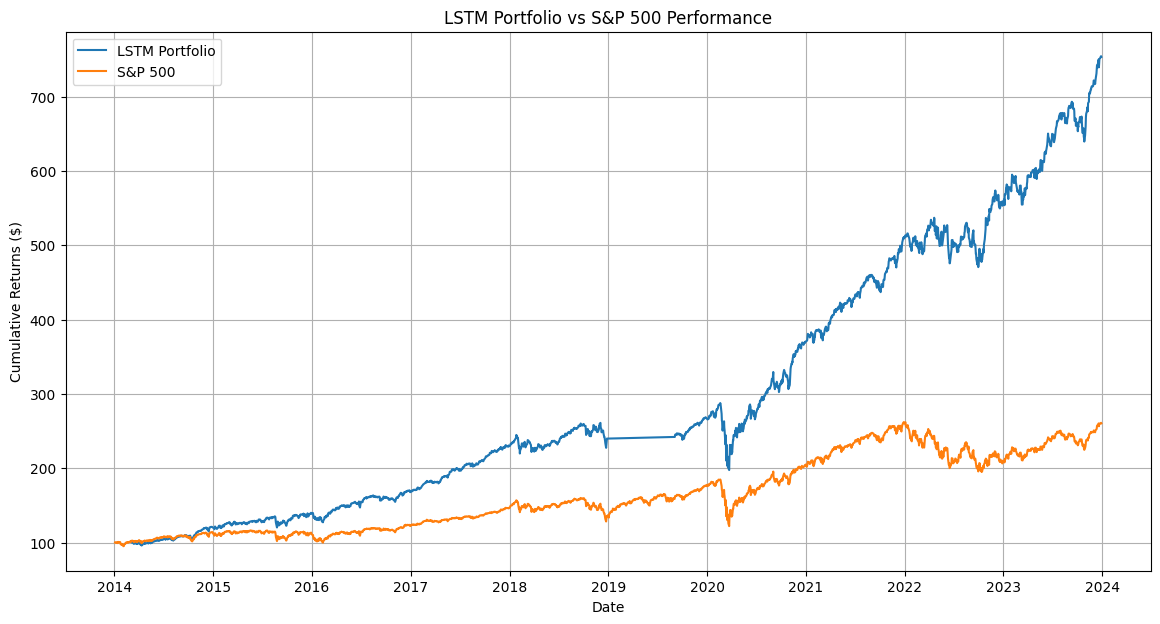

In [34]:

sp500_data = yf.download('^GSPC', start=f"{start_year}-01-01", end=f"{end_year}-12-31")['Adj Close']
sp500_cumulative_returns = (1 + sp500_data.pct_change().dropna()).cumprod() * initial_investment

# Ensure indices are DatetimeIndex
final_lstm_cumulative_returns.index = pd.to_datetime(final_lstm_cumulative_returns.index)
sp500_cumulative_returns.index = pd.to_datetime(sp500_cumulative_returns.index)

# Plot portfolio vs. S&P 500
plt.figure(figsize=(14, 7))
plt.plot(final_lstm_cumulative_returns, label='LSTM Portfolio')
plt.plot(sp500_cumulative_returns, label='S&P 500')
plt.title('LSTM Portfolio vs S&P 500 Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns ($)')
plt.legend()
plt.grid(True)
plt.show()


## Compare LSTM and S&P500 Metrics

In [35]:
# Function to compute performance metrics (same as before)
def calculate_performance_metrics(returns_series, risk_free_rate=0.0):
    # Check if the series is empty
    if returns_series.empty:
        raise ValueError("The returns series is empty. Check your data and calculations.")

    # Calculate total return
    total_return = returns_series.iloc[-1] / returns_series.iloc[0] - 1

    # Calculate the number of years in the returns series
    num_years = (returns_series.index[-1] - returns_series.index[0]).days / 365.25

    # Calculate annualized return
    annualized_return = (1 + total_return) ** (1 / num_years) - 1

    # Calculate annualized volatility
    annualized_volatility = returns_series.pct_change().std() * np.sqrt(252)

    # Calculate Sharpe ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio
    }

# Calculate metrics for the LSTM portfolio
lstm_metrics = calculate_performance_metrics(final_lstm_cumulative_returns)

# Calculate metrics for the S&P 500
sp500_metrics = calculate_performance_metrics(sp500_cumulative_returns)

# Convert S&P 500 metrics into scalar values (remove index metadata)
sp500_metrics_cleaned = {key: float(value) for key, value in sp500_metrics.items()}

# Create a DataFrame with the metrics for comparison
metrics_df = pd.DataFrame(
    [lstm_metrics, sp500_metrics_cleaned], 
    index=['LSTM Portfolio', 'S&P 500']
)

# Display the metrics
print("\nLSTM Portfolio vs. S&P 500 Performance Metrics:")
metrics_df



LSTM Portfolio vs. S&P 500 Performance Metrics:


C:\Users\Alec\AppData\Local\Temp\ipykernel_21876\752861661.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sp500_metrics_cleaned = {key: float(value) for key, value in sp500_metrics.items()}


,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio
LSTM Portfolio,6.524002,0.228344,0.170339,1.34053
S&P 500,1.604515,0.100615,0.177414,0.56712


# Evaluate XGBooster and LSTM Models 

In [36]:

f1_scores_lstm_per_year = [float(score) for score in f1_scores_lstm_per_year.values()]
f1_scores_xgb_per_year = [float(score) for score in f1_scores_per_year.values()]


# --------------------------------------------
# Perform Statistical Analysis
# --------------------------------------------

# Print the collected F1-scores
print(f"\nYearly LSTM F1-scores: {f1_scores_lstm_per_year}")
print(f"Yearly XGBoost F1-scores: {f1_scores_xgb_per_year}")

# Compute the mean and standard deviation of the F1-scores
print(f"LSTM F1-Score Mean: {np.mean(f1_scores_lstm_per_year):.4f}, Std Dev: {np.std(f1_scores_lstm_per_year):.4f}")
print(f"XGBoost F1-Score Mean: {np.mean(f1_scores_xgb_per_year):.4f}, Std Dev: {np.std(f1_scores_xgb_per_year):.4f}")

# Perform a paired t-test to compare the models' F1-scores across years
t_stat, p_value_t = ttest_rel(f1_scores_lstm_per_year, f1_scores_xgb_per_year)
print(f"\nPaired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value_t:.4f}")



Yearly LSTM F1-scores: [0.7459026841126668, 0.6120863889361532, 0.7279404606649508, 0.7551685754533152, 0.6864307931177419, 0.5927779700830115, 0.7995917706973581, 0.7010869427349943, 0.6814483322374034, 0.73411967806388]
Yearly XGBoost F1-scores: [0.6912570764487068, 0.6324735978940398, 0.7177369654128004, 0.7535121348949423, 0.6378507970883668, 0.6104350313511163, 0.7829719966475156, 0.7145553418045211, 0.6584179667528244, 0.7290439242970163]
LSTM F1-Score Mean: 0.7037, Std Dev: 0.0605
XGBoost F1-Score Mean: 0.6928, Std Dev: 0.0537

Paired t-test: t-statistic = 1.3240, p-value = 0.2181


# Comparing Performance of XGBoost, LSTM, and S&P500

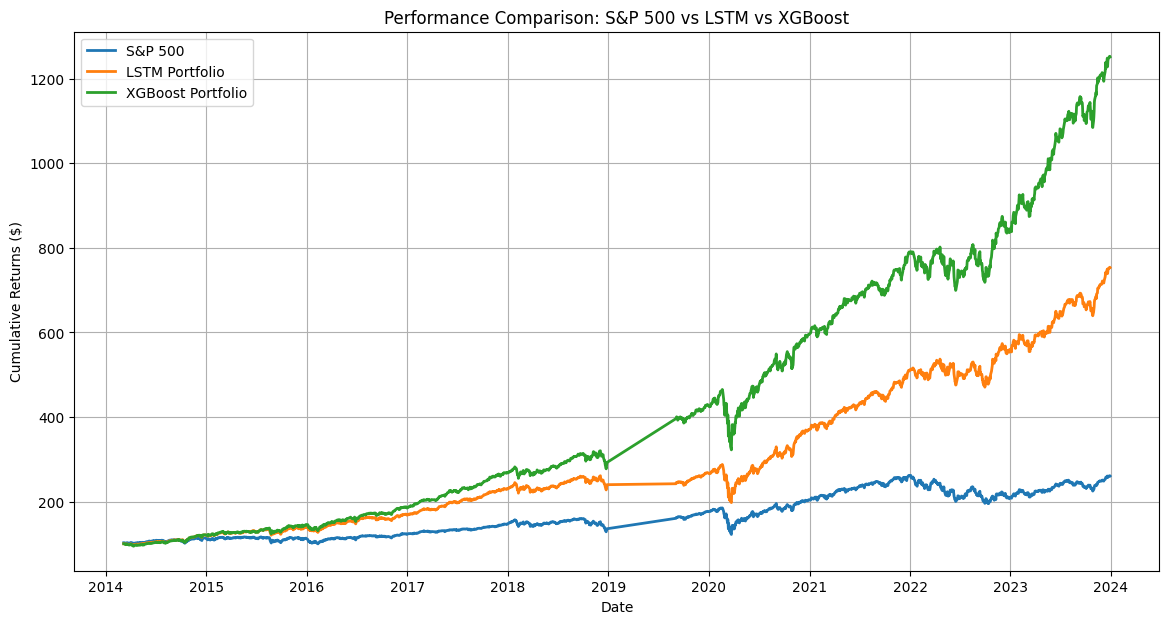

In [37]:
# Ensure cumulative returns for XGBoost, LSTM, and S&P 500 are aligned
combined_data = pd.concat(
    [sp500_cumulative_returns, final_lstm_cumulative_returns, final_cumulative_returns],
    axis=1, 
    join='inner'
)
combined_data.columns = ['S&P 500', 'LSTM Portfolio', 'XGBoost Portfolio']

# Plot the performance over time
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['S&P 500'], label='S&P 500', linewidth=2)
plt.plot(combined_data.index, combined_data['LSTM Portfolio'], label='LSTM Portfolio', linewidth=2)
plt.plot(combined_data.index, combined_data['XGBoost Portfolio'], label='XGBoost Portfolio', linewidth=2)

# Customize the plot
plt.title('Performance Comparison: S&P 500 vs LSTM vs XGBoost')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns ($)')
plt.legend(loc="upper left")
plt.grid(True)

# Show the plot
plt.show()


In [38]:
# Function to compute performance metrics (same as before)
def calculate_performance_metrics(returns_series, risk_free_rate=0.0):
    # Check if the series is empty
    if returns_series.empty:
        raise ValueError("The returns series is empty. Check your data and calculations.")

    # Calculate total return
    total_return = returns_series.iloc[-1] / returns_series.iloc[0] - 1

    # Calculate the number of years in the returns series
    num_years = (returns_series.index[-1] - returns_series.index[0]).days / 365.25

    # Calculate annualized return
    annualized_return = (1 + total_return) ** (1 / num_years) - 1

    # Calculate annualized volatility
    annualized_volatility = returns_series.pct_change().std() * np.sqrt(252)

    # Calculate Sharpe ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio
    }

# Calculate metrics for the LSTM portfolio
lstm_metrics = calculate_performance_metrics(final_lstm_cumulative_returns)

# Calculate metrics for the XGBoost portfolio (use final cumulative returns for XGBoost)
xgb_metrics = calculate_performance_metrics(final_cumulative_returns)

# Calculate metrics for the S&P 500
sp500_metrics = calculate_performance_metrics(sp500_cumulative_returns)

# Convert S&P 500 metrics into scalar values (remove index metadata)
sp500_metrics_cleaned = {key: float(value) for key, value in sp500_metrics.items()}

# Create a DataFrame with the metrics for comparison
metrics_df = pd.DataFrame(
    [lstm_metrics, xgb_metrics, sp500_metrics_cleaned], 
    index=['LSTM Portfolio', 'XGBoost Portfolio', 'S&P 500']
)

# Display the metrics
print("\nLSTM Portfolio, XGBoost Portfolio vs. S&P 500 Performance Metrics:")
metrics_df



LSTM Portfolio, XGBoost Portfolio vs. S&P 500 Performance Metrics:


C:\Users\Alec\AppData\Local\Temp\ipykernel_21876\1028473966.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sp500_metrics_cleaned = {key: float(value) for key, value in sp500_metrics.items()}


,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio
LSTM Portfolio,6.524002,0.228344,0.170339,1.340530
XGBoost Portfolio,11.505155,0.293617,0.169760,1.729605
S&P 500,1.604515,0.100615,0.177414,0.567120


# Used to download stock datasets
For purpose of playing with...
- Dataset size
- Feature list
- Timeframe


In [21]:
'''

# Step 1: Get the list of S&P 500 tickers
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(sp500_url)
tickers = sp500_table[0]['Symbol'].tolist()

# Step 2: Retrieve stock data for all tickers and calculate market capitalization
market_caps = []

for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)

        # Get current stock price and shares outstanding
        stock_info = stock.info
        current_price = stock_info.get('currentPrice', None)
        shares_outstanding = stock_info.get('sharesOutstanding', None)

        # Calculate market capitalization if data is available
        if current_price is not None and shares_outstanding is not None:
            market_cap = current_price * shares_outstanding
            market_caps.append((ticker, market_cap))
        else:
            print(f"Missing data for {ticker}")
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

# Step 3: Create a DataFrame and sort by market capitalization
df = pd.DataFrame(market_caps, columns=['Ticker', 'MarketCap'])
df = df.sort_values(by='MarketCap', ascending=False)

# Select the top 7 companies
top_100_tickers = df['Ticker'].head(100).tolist() ### MAKE SURE TO CHANGE THIS WHEN GOING FROM 7 TO 100

# Step 4: Download stock data for the top 7 tickers over the last 10 years
start_date = "2013-11-08"
end_date = "2024-11-08"
all_data = []

for ticker in top_100_tickers:
    try:
        # Retrieve stock data
        data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
        data.columns = data.columns.get_level_values(0)

        # Reset the index to make the date a column
        data.reset_index(inplace=True)

        # Keep essential price data and add the ticker name
        data = data[['Date', 'Close', 'High', 'Low', 'Open', 'Volume']]
        data['Ticker'] = ticker

        # Get stock information for the current ticker
        stock_info = yf.Ticker(ticker).info

        # Step 5: Calculate Technical Indicators
        data['Moving_Avg_50'] = data['Close'].rolling(window=50).mean()
        data['Moving_Avg_10'] = data['Close'].rolling(window=10).mean()
        data['Volatility_10'] = data['Close'].rolling(window=10).std()
        data['Net_Price_Change_2d'] = data['Close'].diff(2)
        data['Alpha'] = data['Close'] / data['Volume']
        data['Beta'] = data['Close'].pct_change()

        # Retrieve and assign financial metrics from stock_info
        ebitda = stock_info.get('ebitda', None)
        pe_ratio = stock_info.get('trailingPE', None)
        enterprise_value = stock_info.get('enterpriseValue', None)

        # Assign only if data is available
        data['EBITDA'] = ebitda if ebitda is not None else 0
        data['PE_Ratio'] = pe_ratio if pe_ratio is not None else 0
        data['Enterprise_Value'] = enterprise_value if enterprise_value is not None else 0

        # Step 6: Create 30 lagged features for all columns (except 'Ticker' and 'Date')
        for lag in range(1, 31):
            for column in ['Close', 'High', 'Low', 'Open', 'Volume', 'Moving_Avg_50',
                           'Moving_Avg_10', 'Volatility_10', 'Net_Price_Change_2d', 'Alpha', 'Beta']:
                data[f'{column}_Lag_{lag}'] = data[column].shift(lag)

        # Add to the list of all data
        all_data.append(data)
    except Exception as e:
        print(f"Could not download data for {ticker}: {e}")

# Combine all the stock data into a single DataFrame
if all_data:
    all_stocks_data = pd.concat(all_data)
    
    # Step 7: Drop rows with NaN values due to rolling calculations and lagged features
    all_stocks_data.dropna(inplace=True)

    # Step 8: Save the DataFrame to a CSV file
    #file_name = "top_7_sp500_stock_data.csv"
    file_name = "top_100_sp500_stock_data.csv"
    all_stocks_data.to_csv(file_name, index=False)
    print(f"Data saved to {file_name}.")
else:
    print("No data was downloaded for the selected tickers.")
'''

'\n\n# Step 1: Get the list of S&P 500 tickers\nsp500_url = \'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies\'\nsp500_table = pd.read_html(sp500_url)\ntickers = sp500_table[0][\'Symbol\'].tolist()\n\n# Step 2: Retrieve stock data for all tickers and calculate market capitalization\nmarket_caps = []\n\nfor ticker in tickers:\n    try:\n        stock = yf.Ticker(ticker)\n\n        # Get current stock price and shares outstanding\n        stock_info = stock.info\n        current_price = stock_info.get(\'currentPrice\', None)\n        shares_outstanding = stock_info.get(\'sharesOutstanding\', None)\n\n        # Calculate market capitalization if data is available\n        if current_price is not None and shares_outstanding is not None:\n            market_cap = current_price * shares_outstanding\n            market_caps.append((ticker, market_cap))\n        else:\n            print(f"Missing data for {ticker}")\n    except Exception as e:\n        print(f"Could not retrieve data